**Dimensional_Reduction**

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [9]:
df = pd.read_csv('./Data/car_price_preprocessed.csv')
print(df.columns.tolist())


['car_ID', 'symboling', 'CarName', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'CarBrand_alfa-romero', 'CarBrand_audi', 'CarBrand_bmw', 'CarBrand_buick', 'CarBrand_chevrolet', 'CarBrand_dodge', 'CarBrand_honda', 'CarBrand_isuzu', 'CarBrand_jaguar', 'CarBrand_mazda', 'CarBrand_mercury', 'CarBrand_mitsubishi', 'CarBrand_nissan', 'CarBrand_peugeot', 'CarBrand_plymouth', 'CarBrand_porsche', 'CarBrand_renault', 'CarBrand_saab', 'CarBrand_subaru', 'CarBrand_toyota', 'CarBrand_volkswagen', 'CarBrand_volvo', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo', 'doornumber_four', 'doornumber_two', 'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv', 'enginetyp

In [10]:
features = [col for col in df.columns if col not in ["car_ID", "CarName"]]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**PCA**

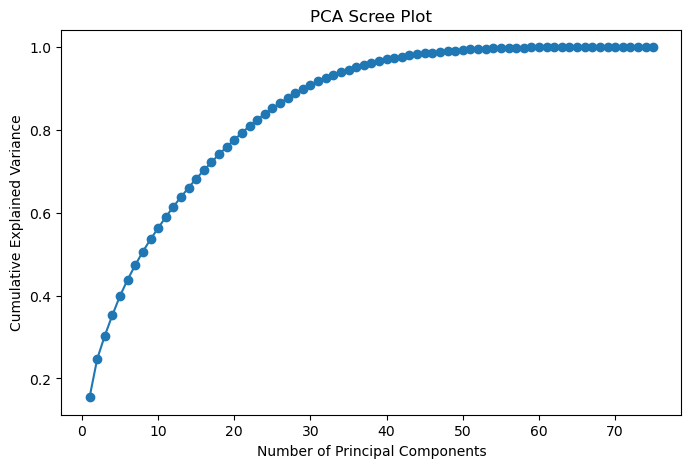

In [3]:
features = [col for col in df.columns if col not in ["car_ID", "CarName"]]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 完整 PCA，用于碎石图
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [4]:
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of principal components retained: {X_pca.shape[1]}")

pc_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca.to_csv("PCA/car_price_pca.csv", index=False)
print("Saved PCA results to PCA/car_price_pca.csv")

Number of principal components retained: 16
Saved PCA results to PCA/car_price_pca.csv


**AE**

In [31]:
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),


            nn.Linear(128, input_dim)
            # 没有激活函数，默认回归输出（适配 MSE）
        )

    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, loss function, optimizer, and learning rate scheduler
model = Autoencoder(X_scaled.shape[1], 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1500
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        # Forward pass
        encoded, decoded = model(data)
        loss = criterion(decoded, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations
model.eval()
with torch.no_grad():
    encoded_data, _ = model(X_tensor)
    encoded_data = encoded_data.numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'AE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('AE/car_price_ae.csv', index=False)

Epoch [10/1500], Loss: 0.9165
Epoch [20/1500], Loss: 0.7122
Epoch [30/1500], Loss: 0.5055
Epoch [40/1500], Loss: 0.4294
Epoch [50/1500], Loss: 0.3560
Epoch [60/1500], Loss: 0.2492
Epoch [70/1500], Loss: 0.1940
Epoch [80/1500], Loss: 0.1470
Epoch [90/1500], Loss: 0.1345
Epoch [100/1500], Loss: 0.0963
Epoch [110/1500], Loss: 0.0833
Epoch [120/1500], Loss: 0.0798
Epoch [130/1500], Loss: 0.0661
Epoch [140/1500], Loss: 0.0578
Epoch [150/1500], Loss: 0.0562
Epoch [160/1500], Loss: 0.0512
Epoch [170/1500], Loss: 0.0522
Epoch [180/1500], Loss: 0.0427
Epoch [190/1500], Loss: 0.0445
Epoch [200/1500], Loss: 0.0363
Epoch [210/1500], Loss: 0.0331
Epoch [220/1500], Loss: 0.0337
Epoch [230/1500], Loss: 0.0354
Epoch [240/1500], Loss: 0.0309
Epoch [250/1500], Loss: 0.0259
Epoch [260/1500], Loss: 0.0199
Epoch [270/1500], Loss: 0.0248
Epoch [280/1500], Loss: 0.0262
Epoch [290/1500], Loss: 0.0271
Epoch [300/1500], Loss: 0.0238
Epoch [310/1500], Loss: 0.0217
Epoch [320/1500], Loss: 0.0168
Epoch [330/1500],

KeyboardInterrupt: 

**SAE**

Pretraining individual autoencoders...

Pretraining autoencoder 1
Epoch [20/2000], Loss: 0.6565
Epoch [40/2000], Loss: 0.3915
Epoch [60/2000], Loss: 0.2488
Epoch [80/2000], Loss: 0.1595
Epoch [100/2000], Loss: 0.0938
Epoch [120/2000], Loss: 0.0688
Epoch [140/2000], Loss: 0.0617
Epoch [160/2000], Loss: 0.0513
Epoch [180/2000], Loss: 0.0323
Epoch [200/2000], Loss: 0.0347
Epoch [220/2000], Loss: 0.0246
Epoch [240/2000], Loss: 0.0264
Epoch [260/2000], Loss: 0.0211
Epoch [280/2000], Loss: 0.0171
Epoch [300/2000], Loss: 0.0156
Epoch [320/2000], Loss: 0.0151
Epoch [340/2000], Loss: 0.0137
Epoch [360/2000], Loss: 0.0107
Epoch [380/2000], Loss: 0.0121
Epoch [400/2000], Loss: 0.0134
Epoch [420/2000], Loss: 0.0100
Epoch [440/2000], Loss: 0.0082
Epoch [460/2000], Loss: 0.0063
Epoch [480/2000], Loss: 0.0116
Epoch [500/2000], Loss: 0.0081
Epoch [520/2000], Loss: 0.0069
Epoch [540/2000], Loss: 0.0070
Epoch [560/2000], Loss: 0.0081
Epoch [580/2000], Loss: 0.0076
Epoch [600/2000], Loss: 0.0048
Epoch [6

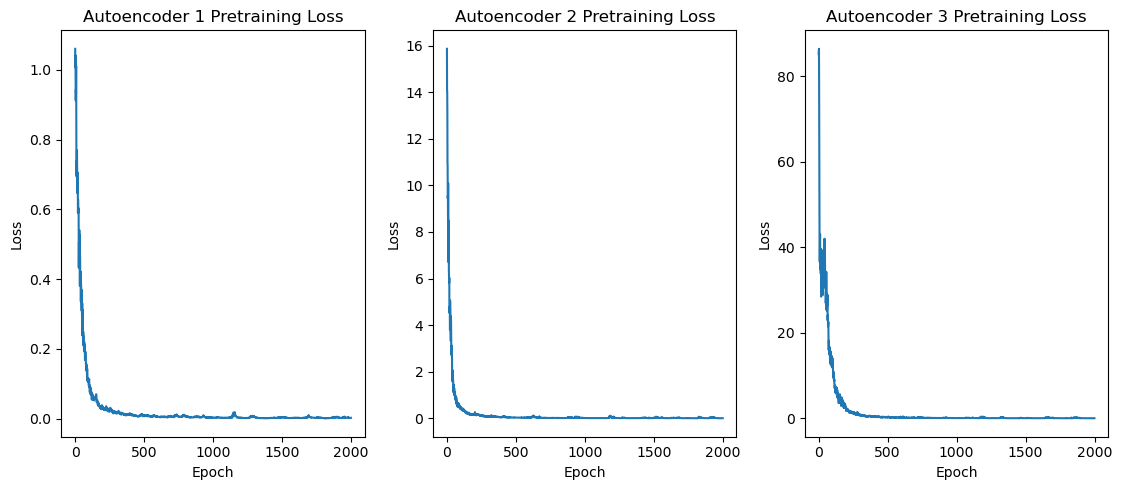


Fine-tuning complete model...
Epoch [10/600], Loss: 0.0045
Epoch [20/600], Loss: 0.0016
Epoch [30/600], Loss: 0.0009
Epoch [40/600], Loss: 0.0010
Epoch [50/600], Loss: 0.0008
Epoch [60/600], Loss: 0.0009
Epoch [70/600], Loss: 0.0007
Epoch [80/600], Loss: 0.0007
Epoch [90/600], Loss: 0.0007
Epoch [100/600], Loss: 0.0006
Epoch [110/600], Loss: 0.0007
Epoch [120/600], Loss: 0.0009
Epoch [130/600], Loss: 0.0009
Epoch [140/600], Loss: 0.0006
Epoch [150/600], Loss: 0.0006
Epoch [160/600], Loss: 0.0009
Epoch [170/600], Loss: 0.0006
Epoch [180/600], Loss: 0.0008
Epoch [190/600], Loss: 0.0006
Epoch [200/600], Loss: 0.0007
Epoch [210/600], Loss: 0.0006
Epoch [220/600], Loss: 0.0007
Epoch [230/600], Loss: 0.0007
Epoch [240/600], Loss: 0.0009
Epoch [250/600], Loss: 0.0007
Epoch [260/600], Loss: 0.0008
Epoch [270/600], Loss: 0.0007
Epoch [280/600], Loss: 0.0007
Epoch [290/600], Loss: 0.0005
Epoch [300/600], Loss: 0.0008
Epoch [310/600], Loss: 0.0008
Epoch [320/600], Loss: 0.0005
Epoch [330/600], L

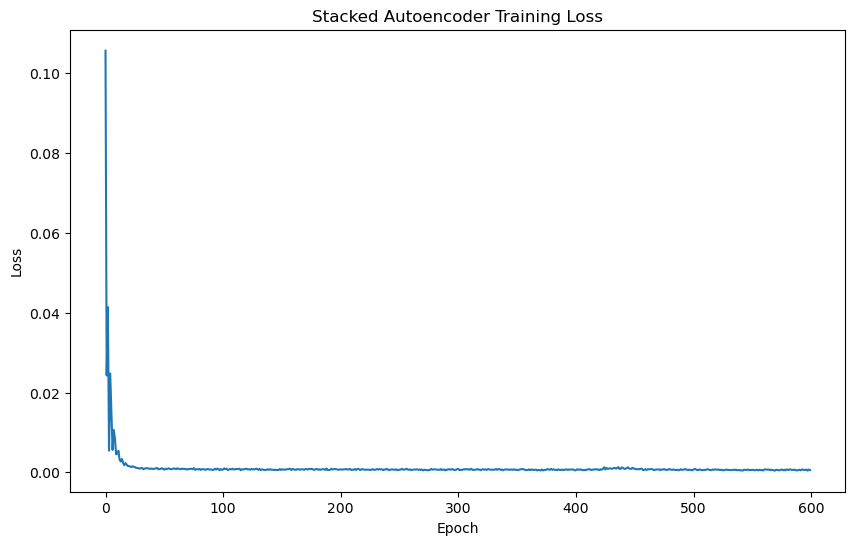

In [32]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,512),

            nn.ReLU(),


            nn.Linear(512, 256),

            nn.ReLU(),
            nn.Linear(256, 128),

            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, encoding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),


            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded



class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dims):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Create stack of autoencoders
        curr_dim = input_dim
        for encoding_dim in encoding_dims:
            self.autoencoders.append(DeepAutoencoder(curr_dim, encoding_dim))
            curr_dim = encoding_dim
            
    def forward(self, x):
        encoded = x
        encoded_features = []
        for autoencoder in self.autoencoders:
            encoded = autoencoder.encoder(encoded)
            encoded_features.append(encoded)
            
        # Decode in reverse order
        decoded = encoded
        for autoencoder in reversed(self.autoencoders):
            decoded = autoencoder.decoder(decoded)
            
        return decoded, encoded_features

encoding_dims = [256,64,16]  # Progressive reduction in dimensions

model = StackedAutoencoder(X_scaled.shape[1], encoding_dims)
criterion = nn.MSELoss()

# Pretrain each autoencoder layer
print("Pretraining individual autoencoders...")
curr_input = X_tensor
pretrain_losses = []  # To store losses for each autoencoder
for i, autoencoder in enumerate(model.autoencoders):
    print(f"\nPretraining autoencoder {i+1}")
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    
    pretrain_epochs = 2000
    losses = []  # Store losses for the current autoencoder
    for epoch in range(pretrain_epochs):
        for data, _ in dataloader:
            if i > 0:
                with torch.no_grad():
                    for j in range(i):
                        data = model.autoencoders[j].encoder(data)
            
            encoded = autoencoder.encoder(data)
            decoded = autoencoder.decoder(encoded)
            loss = criterion(decoded, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{pretrain_epochs}], Loss: {loss.item():.4f}')
    
    pretrain_losses.append(losses)  # Store losses for plotting

# Plot pretraining losses for each autoencoder
plt.figure(figsize=(15, 5))
for i, losses in enumerate(pretrain_losses):
    plt.subplot(1, 4, i + 1)
    plt.plot(losses)
    plt.title(f'Autoencoder {i + 1} Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Fine-tune the entire model
print("\nFine-tuning complete model...")
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 600
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        decoded, encoded_features = model(data)
        loss = criterion(decoded, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Stacked Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations (using the final encoding layer)
model.eval()
with torch.no_grad():
    _, encoded_features = model(X_tensor)
    # Get the final encoded representation (32 dimensions)
    encoded_data = encoded_features[-1].numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'SAE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('SAE/car_price_sae.csv', index=False)